In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt

import env
import wrangle
import explore
import evaluate

import warnings
warnings.filterwarnings("ignore")

from pydataset import data

import sklearn as sk
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression, RFE

#### 1. Select a dataset with a continuous target variable.


In [2]:
df = wrangle.wrangle_zillow()

Reading from local CSV...


In [3]:
df.head()

,bedrooms,bathrooms,sqft,tax_value,tax_amount,fips,age
0,4.0,3.0,2090.0,615000.0,8625.75,06037,44
1,5.0,3.0,2479.0,531642.0,6722.67,06037,44
2,4.0,2.0,2057.0,328148.0,4160.63,06037,44
3,4.0,3.0,2423.0,297377.0,3883.47,06037,39
4,4.0,3.0,2226.0,297001.0,3884.27,06037,39


#### 2. Be sure your data is prepared (no missing values, numeric datatypes) and split into samples.


In [4]:
# identify target
target = 'tax_value'

# identify quantitative features
quant_features = ['bedrooms', 'bathrooms', 'sqft', 'age', 'tax_amount']

# identify categorical features
categ_features = ['fips']

In [5]:
# encode categorical features
for feature in categ_features:
    dummy_df = pd.get_dummies(df[feature],
                              prefix=f'enc_{df[feature].name}',
                              drop_first=True)
    df = pd.concat([df, dummy_df], axis=1)
    
# identify encoded features
enc_features = [col for col in df.columns if col.startswith('enc_')]

In [6]:
train, test, validate = wrangle.train_test_validate_split(df)

train	 n = 1004320
test	 n = 358686
validate n = 430424


In [7]:
# scale quantitative features

# establish empty dataframes for storing scaled dataset
train_scaled = pd.DataFrame(index=train.index)
validate_scaled = pd.DataFrame(index=validate.index)
test_scaled = pd.DataFrame(index=test.index)

# screate and fit the scaler
scaler = MinMaxScaler().fit(train[quant_features])

# adding scaled features to scaled dataframes
train_scaled[quant_features] = scaler.transform(train[quant_features])
validate_scaled[quant_features] = scaler.transform(validate[quant_features])
test_scaled[quant_features] = scaler.transform(test[quant_features])

# add 'scaled' prefix to columns
for feature in quant_features:
    train_scaled = train_scaled.rename(columns={feature: f'scaled_{feature}'})
    validate_scaled = validate_scaled.rename(columns={feature: f'scaled_{feature}'})
    test_scaled = test_scaled.rename(columns={feature: f'scaled_{feature}'})
    
# concat scaled features to original train, validate, test df's
train = pd.concat([train, train_scaled], axis=1)
validate = pd.concat([validate, validate_scaled], axis=1)
test = pd.concat([test, test_scaled], axis=1)

#identify scaled features
scaled_features = [col for col in train.columns if col.startswith('scaled_')]

In [8]:
x_train = train[scaled_features + enc_features]
y_train = train[target]

x_validate = validate[scaled_features + enc_features]
y_validate = validate[target]

x_test = test[scaled_features + enc_features]
y_test = test[target]

#### 3. Work through all of the steps outlined in the lesson, from setting the baseline to selected a model and evaluating the final model on your test data.


In [9]:
def determine_regression_baseline(train, target, return_results_df=False):
    
    # create empty dataframe for storing prediction results
    train_results = pd.DataFrame(index=train.index)
    # assign actual values for the target variable
    train_results['actual'] = train[target]
    # assign a baseline using mean
    train_results['baseline_mean'] = train[target].mean()
    # assign a baseline using median
    train_results['baseline_median']= train[target].median()
    
    # get RMSE values for each potential baseline
    RMSE_baseline_mean = sqrt(sk.metrics.mean_squared_error(train_results.actual, train_results.baseline_mean))
    RMSE_baseline_median = sqrt(sk.metrics.mean_squared_error(train_results.actual, train_results.baseline_median))
    
    # compare the two RMSE values; drop the lowest performer and assign the highest performer to baseline variable
    if RMSE_baseline_median < RMSE_baseline_mean:
        train_results = train_results.drop(columns='baseline_mean')
        train_results['RMSE_baseline'] = RMSE_baseline_median
        baseline = 'median'
    else:
        train_results = train_results.drop(columns='baseline_median')
        train_results['RMSE_baseline'] = RMSE_baseline_mean
        baseline = 'mean'
    
    # return
    if return_results_df:
        return train_results, baseline
    else:
        return baseline

In [10]:
train_results, baseline = determine_regression_baseline(train, target, return_results_df=True)

In [11]:
baseline

'mean'

In [12]:
train_results.head(3)

,actual,baseline_mean,RMSE_baseline
2098827,423291.0,312127.527665,187175.261103
1795578,60274.0,312127.527665,187175.261103
427142,172623.0,312127.527665,187175.261103


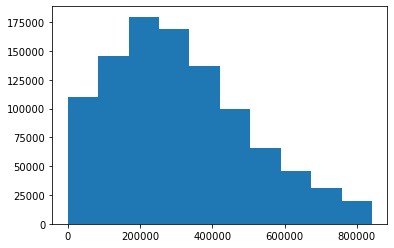

In [13]:
plt.hist(train[target])
plt.show()